In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import niskine
import mplniw.sigp as sp
import mplniw.plot as pl
import mplniw.utils as ut

In [2]:
conf = niskine.io.load_config()
lon, lat, bottom_depth = niskine.io.mooring_location(mooring=1)
root_dir = '/Users/zcasparcohen/codes/NIW/data/'

In [3]:
mooring=1
wind_work = xr.open_dataset(root_dir+'wind_work/ni_wind_work_niskine_m1.nc')
#gridded = xr.open_dataset(root_dir+'data/gridded/M%s_gridded_simple_merge_gaps_filled.nc'%mooring)
#filtered = xr.open_dataset('/Users/zcasparcohen/Documents/NISKINE/data/filtered_convolve.nc')
gridded = xr.open_dataset(root_dir+'M%s_linear_merge_slinearfill.nc'%mooring)

In [4]:
gridded['UV'] = (gridded.u+1j*gridded.v).fillna(0.)
gridded['U'] = (gridded.u).fillna(0.)
gridded['V'] = (gridded.v).fillna(0.)

In [5]:
Nb = 30*24*6
f,E = sp.wrap_spectra(gridded,'UV',Nb=Nb,**{'return_onesided':True})
f_u,E_u = sp.wrap_spectra(gridded,'U',Nb=Nb,**{'return_onesided':True})
f_v,E_v = sp.wrap_spectra(gridded,'V',Nb=Nb,**{'return_onesided':True})

/Users/zcasparcohen/miniconda3/envs/mpl_niw/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:1870: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


/Users/zcasparcohen/miniconda3/envs/mpl_niw/lib/python3.11/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


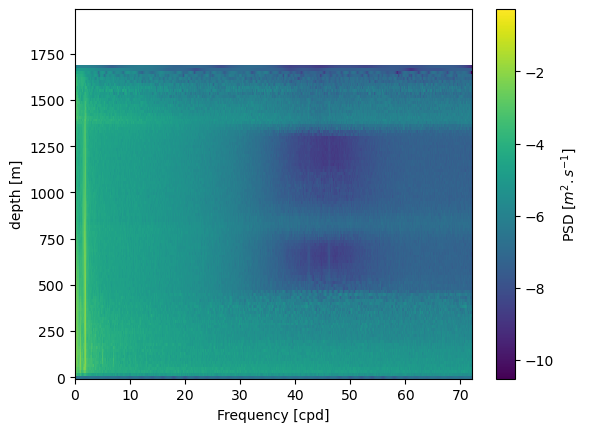

In [6]:
np.log10(E_u).plot()

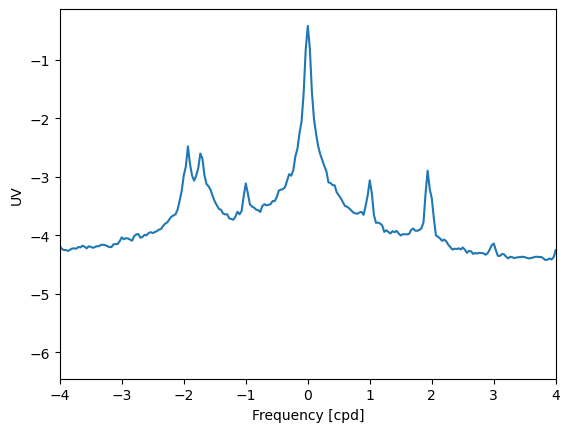

In [7]:
np.log10(E.mean('z')).plot(xlim=(-4,4))

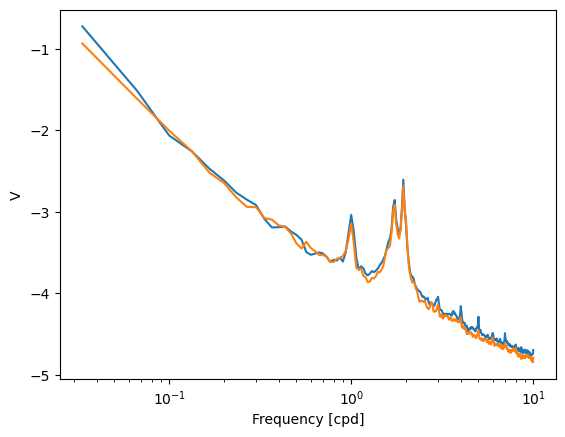

In [8]:
np.log10(E_u.mean('z').sel(freq_time=slice(1e-2,10))).plot(xscale='log')
np.log10(E_v.mean('z').sel(freq_time=slice(1e-2,10))).plot(xscale='log')

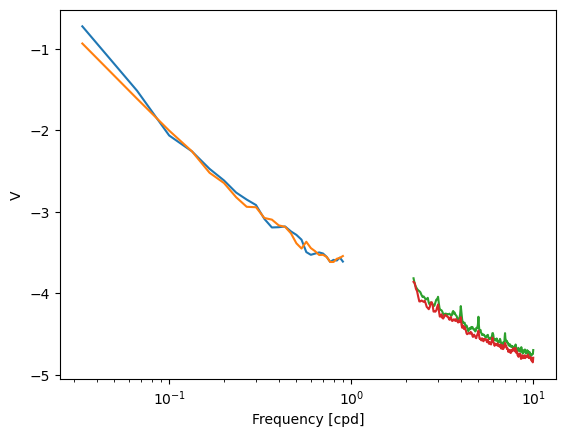

In [9]:
np.log10(E_u.mean('z').sel(freq_time=slice(1e-2,0.9))).plot(xscale='log')
np.log10(E_v.mean('z').sel(freq_time=slice(1e-2,0.9))).plot(xscale='log')

np.log10(E_u.mean('z').sel(freq_time=slice(2.2,10))).plot(xscale='log')
np.log10(E_v.mean('z').sel(freq_time=slice(2.2,10))).plot(xscale='log')


In [10]:
np.log10(E_u.mean('z').where((E_u.freq_time<0.9) & (E_u.freq_time>2.2),drop=True))

<xarray.DataArray 'U' (freq_time: 0)>
array([], dtype=float64)
Coordinates:
  * freq_time  (freq_time) float64

/Users/zcasparcohen/miniconda3/envs/mpl_niw/lib/python3.11/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


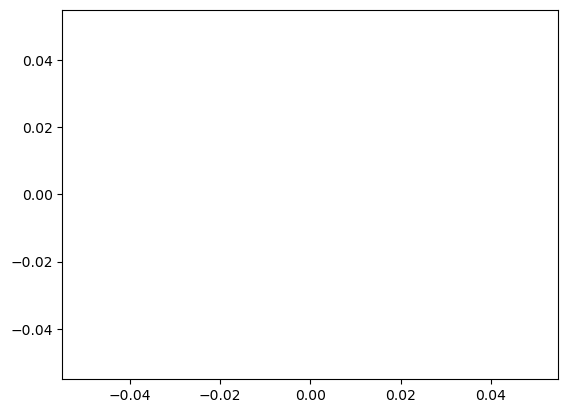

In [63]:
#yp = np.log10(E_u.mean('z').sel(freq_time=slice(1e-2,1)))
yp = np.log10(E_u.mean('z').where((E_u.freq_time>2.2)&(E_u.freq_time<0.9)))
xp = np.log(yp.freq_time)
plt.plot(xp,yp)

In [11]:
domega = 0.2
omega = ut.coriolis(lat)*3600*24/(2*np.pi)
f_cont = E_u.sel(freq_time=slice(omega-domega/2,omega+domega/2)).freq_time

In [12]:
f_cont

<xarray.DataArray 'freq_time' (freq_time: 6)>
array([1.633333, 1.666667, 1.7     , 1.733333, 1.766667, 1.8     ])
Coordinates:
  * freq_time  (freq_time) float64 1.633 1.667 1.7 1.733 1.767 1.8
Attributes:
    long_name:  Frequency
    units:      cpd

In [13]:
np.interp(np.log(f_cont),xp,yp)

NameError: name 'xp' is not defined

In [14]:
from scipy.optimize import curve_fit

In [29]:
def func(x,a,b):
    return a*x+b
ydata = np.log10(E_u.mean('z').sel(freq_time=slice(1e-2,1))).values[1:]
xdata = f_u[np.where((f_u<1)&(1e-2<f_u))]
popt, pcov = curve_fit(func, np.log10(xdata), ydata)

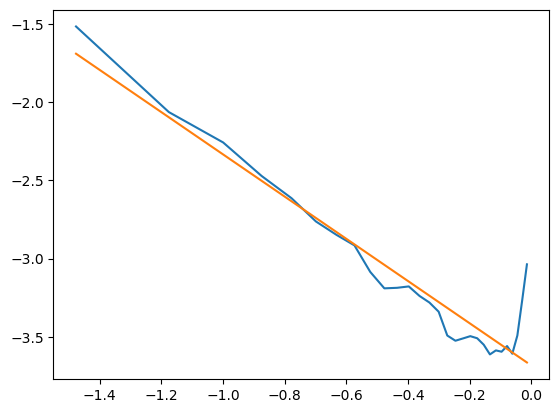

In [33]:
plt.plot(np.log10(xdata),ydata)
plt.plot(np.log10(xdata),popt[0]*np.log10(xdata)+popt[1])
#plt.xscale('log')

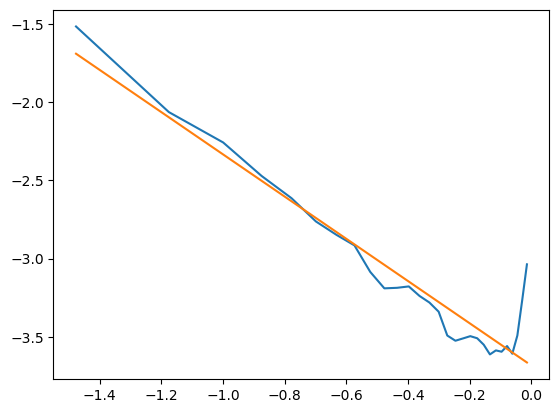

In [41]:
#np.log10(E_u.mean('z').sel(freq_time=slice(1e-2,1))).plot(xscale='log')
#np.log10(E_v.mean('z').sel(freq_time=slice(1e-2,1))).plot(xscale='log')
plt.figure()
plt.plot(np.log10(xdata),ydata)
plt.plot(np.log10(xdata),popt[0]*np.log10(xdata)+popt[1])
#plt.xscale('log')

In [44]:
ynew = np.log10(E_u.mean('z').sel(freq_time=slice(1e-2,10)))
xnew = ynew.freq_time

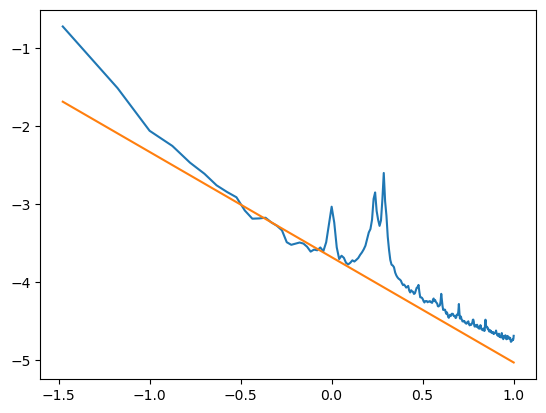

In [45]:
plt.figure()
plt.plot(np.log10(xnew),ynew)
plt.plot(np.log10(xnew),popt[0]*np.log10(xnew)+popt[1])

In [67]:
def myfunc(x,a,b):
    return a*x+b

def interp_slope(_E, func=myfunc):
    ydata = np.log10(_E).values #[1:]
    xdata = _E.freq_time.values
    popt, pcov = curve_fit(func, np.log10(xdata), ydata)
    #ds_out = xr.Dataset({'a':(['dim_a'],popt[0]),'b':(['dim_b'],popt[1]),'dim_a'})
    return popt 

In [68]:
popt = interp_slope(E_u.sel(z=304).sel(freq_time=slice(1e-2,10)),func)


In [69]:
y = E_u.sel(z=304).sel(freq_time=slice(1e-2,10))

In [102]:
_popt = []
z_cont = []
for _z in E_u.z:
    try:
        _popt.append(interp_slope(E_u.sel(z=_z).sel(freq_time=slice(1e-2,10)),func=myfunc))
        z_cont.append(_z)
    except:
        pass

In [124]:
omega = ut.coriolis(lat)*3600*24/(2*np.pi)  # Central frequency
#bandwidth = None 
bandwidth = 0.1

In [125]:
_E_cont = []
for p in _popt:
    x = np.linspace(omega-bandwidth,omega+bandwidth)
    y = p[0]*np.log10(x)+p[1]
    _E_cont.append(np.mean(y))

In [126]:
__e = []
for e in _E_cont:
    __e.append(10**e)

/Users/zcasparcohen/miniconda3/envs/mpl_niw/lib/python3.11/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


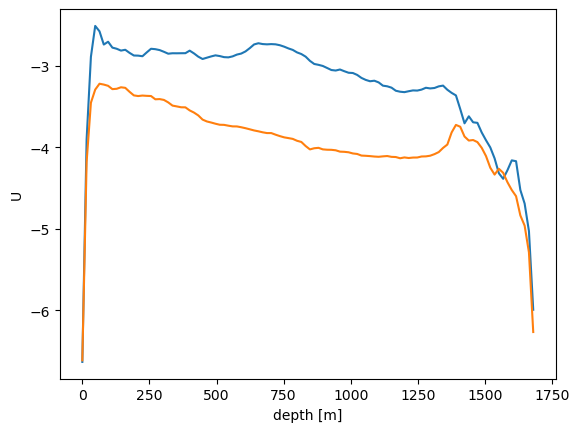

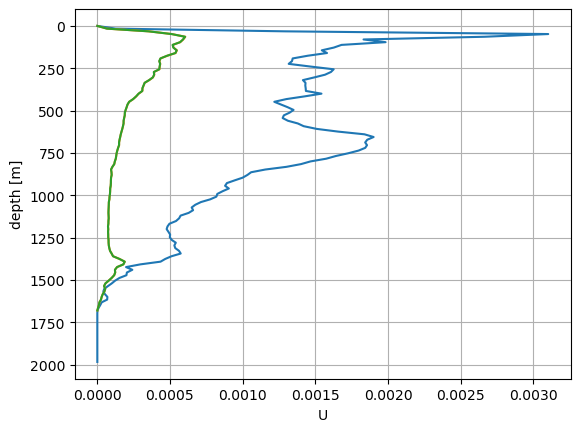

In [127]:
np.log10(E_u.sel(freq_time=slice(omega-bandwidth,omega+bandwidth)).mean('freq_time')).plot()
plt.plot(z_cont,E_cont)

plt.figure()
E_u.sel(freq_time=slice(omega-bandwidth,omega+bandwidth)).mean('freq_time').plot(y='z',yincrease=False)
plt.plot(_e,z_cont)
plt.plot(__e,z_cont)
plt.grid()

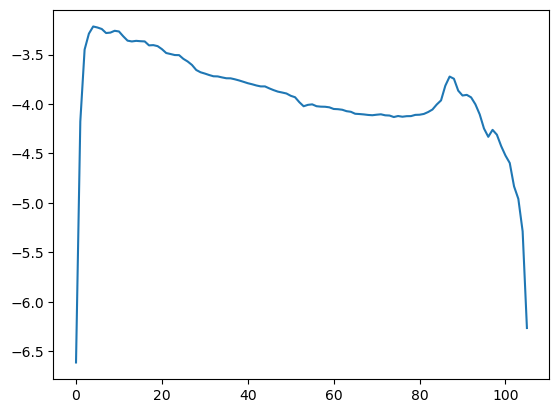

In [98]:
v

In [74]:
xr.apply_ufunc(
            interp_slope,
            E_u.sel(freq_time=slice(1e-2,10)),
            dask="parallelized",
            output_dtypes=[np.float64],
            input_core_dims=[["freq_time"]],
            output_core_dims=[["freq_time"]],
            kwargs={'func':myfunc})

/var/folders/vl/tj6snrv54zd212pkvk5g_l140000gn/T/ipykernel_2542/656923371.py:5: RuntimeWarning: divide by zero encountered in log10
  ydata = np.log10(_E).values #[1:]


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [66]:
xr.Dataset({'a':(['dim_a'],popt[0]),'b':(['dim_b'],popt[1]),'dim_a':(['dim_a'],y.z),'dim_b':(['dim_b'],y.z)})

ValueError: Could not convert tuple of form (dims, data[, attrs, encoding]): (['dim_a'], -1.4718020890417365) to Variable.